## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np

In [19]:
#es 1
file_name="../data/data_000637.txt"
data=pd.read_csv(file_name)
n_r=data.shape[0]
N=np.random.randint(10000,n_r)
data2=pd.read_csv(file_name, nrows=N)
data2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


In [12]:
#es2 
x=data['BX_COUNTER'].max()
print(x)

In [17]:
#es 3
max_orbit=data['ORBIT_CNT'].max()
y=data['ORBIT_CNT'].max()- data['ORBIT_CNT'].min()
print(y)
data3=data[data['ORBIT_CNT']==max_orbit]
max_bx=data3['BX_COUNTER'].max()
print(max_bx)
data4=data3[data3['BX_COUNTER']==max_bx]
data4


11004
769


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1310718,1,0,139,3869211171,769,0


In [18]:
print('data taking last:',max_orbit*25*x + max_bx*25)

data taking last: 344649985076050


In [20]:
#es 4
data['timens']=data['TDC_MEAS']*25/30+data['BX_COUNTER']*25+data['ORBIT_CNT']*25*x
data

In [22]:
#es 5
data['HEAD']=np.random.randint(0,2,n_r)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,0,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,0,0,63,3869200167,2553,28,3.446490e+14
3,0,0,64,3869200167,2558,19,3.446490e+14
4,0,0,64,3869200167,2760,25,3.446490e+14
5,1,0,63,3869200167,2762,4,3.446490e+14
6,0,0,61,3869200167,2772,14,3.446490e+14
7,1,0,139,3869200167,2776,0,3.446490e+14
8,1,0,62,3869200167,2774,21,3.446490e+14
9,0,0,60,3869200167,2788,7,3.446490e+14


In [23]:
#es 6 
data5= data[data['HEAD']==1]
data5

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
1,1,0,124,3869200167,2374,27,3.446490e+14
5,1,0,63,3869200167,2762,4,3.446490e+14
7,1,0,139,3869200167,2776,0,3.446490e+14
8,1,0,62,3869200167,2774,21,3.446490e+14
10,1,1,7,3869200167,2785,4,3.446490e+14
11,1,0,64,3869200167,2786,19,3.446490e+14
14,1,0,56,3869200167,2789,3,3.446490e+14
17,1,0,63,3869200167,2790,10,3.446490e+14
18,1,1,5,3869200167,2795,4,3.446490e+14
22,1,0,61,3869200167,2790,23,3.446490e+14


In [24]:
data5.shape[0]

655667

C:\Users\saret\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


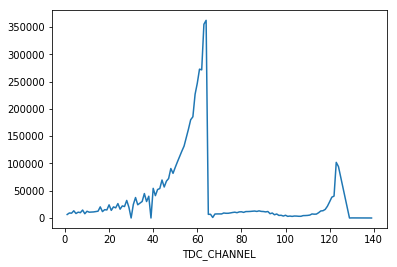

In [48]:
#es 7
data6=data2[data['FPGA']==0]
data7=data6.groupby('TDC_CHANNEL').sum()
plot1=pd.Series(data7['TDC_MEAS'], index=data7.index)
plot1.plot()



C:\Users\saret\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


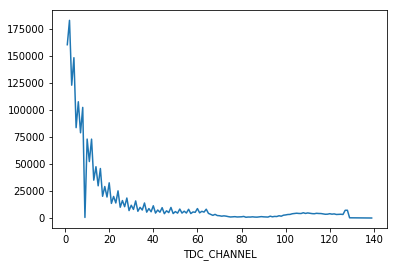

In [50]:
#es 7 bis
data8=data2[data['FPGA']==1]
data9=data8.groupby('TDC_CHANNEL').sum()
plot2=pd.Series(data9['TDC_MEAS'], index=data9.index)
plot2.plot()


In [55]:
#es 8
data7.sort_values('TDC_MEAS')

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
139,29561,0,114377501213601,52755272,0
39,1,0,3869204964,2005,2
30,2,0,7738407269,4724,19
129,2,0,7738405323,3452,28
137,9,0,34822821824,12539,71
138,10,0,38692026319,13628,72
130,12,0,46430428025,12131,173
67,63,0,243759769417,105500,980
103,197,0,762232962036,351040,2970


In [56]:
#es 8 bis
data9.sort_values('TDC_MEAS')

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS
TDC_CHANNEL,,,,,
139,12604,12604,48767431023969,22628768,0
138,12,12,46430431462,15317,60
137,12,12,46430431462,15317,168
130,14,14,54168834322,31277,183
129,11,11,42561228000,14548,197
9,37,37,143160495272,70121,514
82,57,57,220544545173,101667,692
87,59,59,228282950378,105563,801
92,65,65,251498174505,120255,872


In [71]:
#es 9
data2.groupby('ORBIT_CNT').size()
unique_orbit=data2.groupby('ORBIT_CNT').size()
unique_orbit=unique_orbit[unique_orbit==1]
unique_orbit

ORBIT_CNT
3869204142    1
dtype: int64

In [79]:
data139=data2[data2['TDC_CHANNEL']==139]
unique_orbit139=data139.groupby('ORBIT_CNT').size()
unique_orbit139=unique_orbit139[unique_orbit139==1]
#unique_orbit139
unique_orbit139.shape[0]

39